In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-67d22ebc-51e0-13ef-d17c-07e930e297dd)


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'siyiwu0330'
os.environ['KAGGLE_KEY'] = '72addd43edb3d947d8023c1b14d99608'

In [3]:
!kaggle datasets download -d soumikrakshit/anime-faces

 98% 434M/441M [00:07<00:00, 70.5MB/s]
100% 441M/441M [00:07<00:00, 65.0MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('/content/anime-faces.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [5]:
import os
len(os.listdir('/content/data/data'))

21552

In [6]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm_notebook

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)

Random Seed:  999


In [7]:
# Root directory for dataset
dataroot = "/content/data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

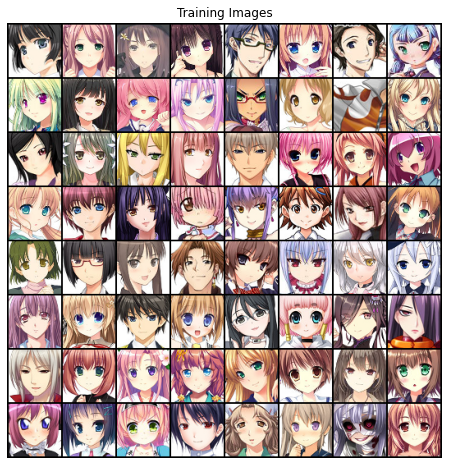

In [8]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in tqdm_notebook(enumerate(dataloader, 0)):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


[0/50][0/337]	Loss_D: 1.4360	Loss_G: 6.2090	D(x): 0.6300	D(G(z)): 0.5419 / 0.0028
[0/50][50/337]	Loss_D: 1.3787	Loss_G: 20.0734	D(x): 0.5450	D(G(z)): 0.0000 / 0.0000
[0/50][100/337]	Loss_D: 0.4543	Loss_G: 6.8813	D(x): 0.8058	D(G(z)): 0.0604 / 0.0022
[0/50][150/337]	Loss_D: 0.7589	Loss_G: 8.3326	D(x): 0.6191	D(G(z)): 0.0014 / 0.0012
[0/50][200/337]	Loss_D: 0.5103	Loss_G: 6.4187	D(x): 0.8573	D(G(z)): 0.2348 / 0.0025
[0/50][250/337]	Loss_D: 0.6745	Loss_G: 6.1003	D(x): 0.8259	D(G(z)): 0.2233 / 0.0036
[0/50][300/337]	Loss_D: 1.2431	Loss_G: 9.0669	D(x): 0.9357	D(G(z)): 0.6037 / 0.0005



[1/50][0/337]	Loss_D: 0.6898	Loss_G: 6.8336	D(x): 0.6425	D(G(z)): 0.0108 / 0.0026
[1/50][50/337]	Loss_D: 0.5357	Loss_G: 4.7557	D(x): 0.7088	D(G(z)): 0.0231 / 0.0158
[1/50][100/337]	Loss_D: 0.3842	Loss_G: 6.3629	D(x): 0.7760	D(G(z)): 0.0295 / 0.0033
[1/50][150/337]	Loss_D: 0.5374	Loss_G: 6.8139	D(x): 0.8622	D(G(z)): 0.2686 / 0.0017
[1/50][200/337]	Loss_D: 2.4904	Loss_G: 8.4719	D(x): 0.1819	D(G(z)): 0.0001 / 0.0008
[1/50][250/337]	Loss_D: 1.2241	Loss_G: 8.0513	D(x): 0.4501	D(G(z)): 0.0014 / 0.0009
[1/50][300/337]	Loss_D: 0.8168	Loss_G: 7.1938	D(x): 0.8155	D(G(z)): 0.3909 / 0.0012



[2/50][0/337]	Loss_D: 0.9912	Loss_G: 9.6410	D(x): 0.9021	D(G(z)): 0.5356 / 0.0002
[2/50][50/337]	Loss_D: 0.7061	Loss_G: 6.1858	D(x): 0.8113	D(G(z)): 0.3232 / 0.0029
[2/50][100/337]	Loss_D: 0.5252	Loss_G: 4.9220	D(x): 0.7097	D(G(z)): 0.0445 / 0.0122
[2/50][150/337]	Loss_D: 0.4642	Loss_G: 5.5145	D(x): 0.8812	D(G(z)): 0.2419 / 0.0058
[2/50][200/337]	Loss_D: 0.5095	Loss_G: 4.7762	D(x): 0.8118	D(G(z)): 0.1990 / 0.0112
[2/50][250/337]	Loss_D: 0.4872	Loss_G: 4.5262	D(x): 0.7075	D(G(z)): 0.0320 / 0.0170
[2/50][300/337]	Loss_D: 0.6958	Loss_G: 9.4288	D(x): 0.9470	D(G(z)): 0.4242 / 0.0002



[3/50][0/337]	Loss_D: 0.3872	Loss_G: 6.9362	D(x): 0.8852	D(G(z)): 0.1952 / 0.0015
[3/50][50/337]	Loss_D: 0.1382	Loss_G: 4.1595	D(x): 0.9372	D(G(z)): 0.0571 / 0.0324
[3/50][100/337]	Loss_D: 0.6041	Loss_G: 7.0834	D(x): 0.9669	D(G(z)): 0.3862 / 0.0018
[3/50][150/337]	Loss_D: 0.4560	Loss_G: 4.0649	D(x): 0.7333	D(G(z)): 0.0361 / 0.0263
[3/50][200/337]	Loss_D: 0.5940	Loss_G: 4.3906	D(x): 0.6546	D(G(z)): 0.0076 / 0.0237
[3/50][250/337]	Loss_D: 0.3269	Loss_G: 5.7435	D(x): 0.8902	D(G(z)): 0.1591 / 0.0053
[3/50][300/337]	Loss_D: 0.3366	Loss_G: 5.4376	D(x): 0.7817	D(G(z)): 0.0264 / 0.0096



[4/50][0/337]	Loss_D: 0.6076	Loss_G: 9.5629	D(x): 0.9645	D(G(z)): 0.3886 / 0.0002
[4/50][50/337]	Loss_D: 0.3879	Loss_G: 5.6047	D(x): 0.7513	D(G(z)): 0.0160 / 0.0066
[4/50][100/337]	Loss_D: 0.5270	Loss_G: 3.9513	D(x): 0.7192	D(G(z)): 0.0508 / 0.0326
[4/50][150/337]	Loss_D: 2.1602	Loss_G: 4.5117	D(x): 0.2689	D(G(z)): 0.0001 / 0.0309
[4/50][200/337]	Loss_D: 0.4656	Loss_G: 11.1289	D(x): 0.7102	D(G(z)): 0.0002 / 0.0000
[4/50][250/337]	Loss_D: 0.5459	Loss_G: 4.9503	D(x): 0.8287	D(G(z)): 0.2062 / 0.0156
[4/50][300/337]	Loss_D: 0.4095	Loss_G: 8.4563	D(x): 0.9717	D(G(z)): 0.2835 / 0.0004



[5/50][0/337]	Loss_D: 0.2635	Loss_G: 5.0345	D(x): 0.9740	D(G(z)): 0.1675 / 0.0259
[5/50][50/337]	Loss_D: 0.2880	Loss_G: 6.8620	D(x): 0.9333	D(G(z)): 0.1742 / 0.0016
[5/50][100/337]	Loss_D: 0.4539	Loss_G: 9.7777	D(x): 0.9920	D(G(z)): 0.3024 / 0.0001
[5/50][150/337]	Loss_D: 0.6515	Loss_G: 8.1710	D(x): 0.9067	D(G(z)): 0.3620 / 0.0005
[5/50][200/337]	Loss_D: 0.5147	Loss_G: 6.7245	D(x): 0.9388	D(G(z)): 0.3075 / 0.0023
[5/50][250/337]	Loss_D: 0.5516	Loss_G: 7.5005	D(x): 0.6696	D(G(z)): 0.0014 / 0.0013
[5/50][300/337]	Loss_D: 0.3397	Loss_G: 3.9767	D(x): 0.8164	D(G(z)): 0.0728 / 0.0303



[6/50][0/337]	Loss_D: 0.4542	Loss_G: 8.1490	D(x): 0.9320	D(G(z)): 0.2823 / 0.0007
[6/50][50/337]	Loss_D: 0.3815	Loss_G: 8.4426	D(x): 0.9256	D(G(z)): 0.2321 / 0.0003
[6/50][100/337]	Loss_D: 0.5644	Loss_G: 4.3892	D(x): 0.6759	D(G(z)): 0.0078 / 0.0238
[6/50][150/337]	Loss_D: 1.7462	Loss_G: 15.0557	D(x): 0.9756	D(G(z)): 0.7582 / 0.0000
[6/50][200/337]	Loss_D: 0.3375	Loss_G: 5.2382	D(x): 0.9007	D(G(z)): 0.1633 / 0.0093
[6/50][250/337]	Loss_D: 0.3160	Loss_G: 6.1115	D(x): 0.9511	D(G(z)): 0.2034 / 0.0040
[6/50][300/337]	Loss_D: 0.2228	Loss_G: 5.0320	D(x): 0.9784	D(G(z)): 0.1629 / 0.0112



[7/50][0/337]	Loss_D: 0.4512	Loss_G: 6.3250	D(x): 0.7186	D(G(z)): 0.0063 / 0.0083
[7/50][50/337]	Loss_D: 0.2934	Loss_G: 5.9938	D(x): 0.9679	D(G(z)): 0.1942 / 0.0060
[7/50][100/337]	Loss_D: 0.7750	Loss_G: 6.8456	D(x): 0.5831	D(G(z)): 0.0014 / 0.0030
[7/50][150/337]	Loss_D: 0.3252	Loss_G: 5.8907	D(x): 0.7908	D(G(z)): 0.0156 / 0.0071
[7/50][200/337]	Loss_D: 0.2662	Loss_G: 4.6693	D(x): 0.8669	D(G(z)): 0.0894 / 0.0169
[7/50][250/337]	Loss_D: 0.1370	Loss_G: 4.1767	D(x): 0.9541	D(G(z)): 0.0763 / 0.0260
[7/50][300/337]	Loss_D: 1.2197	Loss_G: 5.5556	D(x): 0.4127	D(G(z)): 0.0003 / 0.0121



[8/50][0/337]	Loss_D: 0.4117	Loss_G: 4.9375	D(x): 0.7316	D(G(z)): 0.0097 / 0.0151
[8/50][50/337]	Loss_D: 0.5789	Loss_G: 6.5614	D(x): 0.8996	D(G(z)): 0.3104 / 0.0027
[8/50][100/337]	Loss_D: 0.6620	Loss_G: 9.5779	D(x): 0.9555	D(G(z)): 0.3902 / 0.0002
[8/50][150/337]	Loss_D: 1.3843	Loss_G: 5.6000	D(x): 0.3715	D(G(z)): 0.0003 / 0.0105
[8/50][200/337]	Loss_D: 0.2997	Loss_G: 5.8671	D(x): 0.9718	D(G(z)): 0.2101 / 0.0050
[8/50][250/337]	Loss_D: 0.5320	Loss_G: 5.0281	D(x): 0.6730	D(G(z)): 0.0059 / 0.0136
[8/50][300/337]	Loss_D: 0.2075	Loss_G: 5.4809	D(x): 0.9215	D(G(z)): 0.0983 / 0.0087



[9/50][0/337]	Loss_D: 0.2316	Loss_G: 5.9995	D(x): 0.9301	D(G(z)): 0.1268 / 0.0049
[9/50][50/337]	Loss_D: 0.3530	Loss_G: 5.9050	D(x): 0.9110	D(G(z)): 0.1871 / 0.0049
[9/50][100/337]	Loss_D: 0.2927	Loss_G: 4.2633	D(x): 0.8853	D(G(z)): 0.1282 / 0.0227
[9/50][150/337]	Loss_D: 0.3191	Loss_G: 4.9493	D(x): 0.7787	D(G(z)): 0.0161 / 0.0151
[9/50][200/337]	Loss_D: 0.1156	Loss_G: 3.8980	D(x): 0.9640	D(G(z)): 0.0698 / 0.0468
[9/50][250/337]	Loss_D: 0.3785	Loss_G: 7.2435	D(x): 0.9547	D(G(z)): 0.2523 / 0.0016
[9/50][300/337]	Loss_D: 0.6375	Loss_G: 2.3255	D(x): 0.6411	D(G(z)): 0.0521 / 0.1726



[10/50][0/337]	Loss_D: 0.2586	Loss_G: 4.7270	D(x): 0.8491	D(G(z)): 0.0510 / 0.0175
[10/50][50/337]	Loss_D: 0.2834	Loss_G: 3.4385	D(x): 0.8521	D(G(z)): 0.0616 / 0.0553
[10/50][100/337]	Loss_D: 0.3314	Loss_G: 4.5889	D(x): 0.8765	D(G(z)): 0.1458 / 0.0192
[10/50][150/337]	Loss_D: 0.5239	Loss_G: 6.6951	D(x): 0.9384	D(G(z)): 0.3147 / 0.0025
[10/50][200/337]	Loss_D: 0.2661	Loss_G: 3.1010	D(x): 0.8449	D(G(z)): 0.0563 / 0.0779
[10/50][250/337]	Loss_D: 0.1402	Loss_G: 6.1080	D(x): 0.9185	D(G(z)): 0.0396 / 0.0058
[10/50][300/337]	Loss_D: 0.3012	Loss_G: 4.0513	D(x): 0.8546	D(G(z)): 0.0907 / 0.0289



[11/50][0/337]	Loss_D: 0.6554	Loss_G: 7.6542	D(x): 0.9067	D(G(z)): 0.3525 / 0.0011
[11/50][50/337]	Loss_D: 0.5220	Loss_G: 2.1237	D(x): 0.6721	D(G(z)): 0.0287 / 0.1867
[11/50][100/337]	Loss_D: 0.4577	Loss_G: 7.2644	D(x): 0.9492	D(G(z)): 0.2910 / 0.0013
[11/50][150/337]	Loss_D: 0.4909	Loss_G: 4.8418	D(x): 0.7015	D(G(z)): 0.0176 / 0.0245
[11/50][200/337]	Loss_D: 0.2524	Loss_G: 4.1936	D(x): 0.8419	D(G(z)): 0.0523 / 0.0248
[11/50][250/337]	Loss_D: 0.8794	Loss_G: 3.6528	D(x): 0.4996	D(G(z)): 0.0019 / 0.0460
[11/50][300/337]	Loss_D: 1.2793	Loss_G: 2.2976	D(x): 0.4076	D(G(z)): 0.0050 / 0.1832



[12/50][0/337]	Loss_D: 0.4878	Loss_G: 4.7743	D(x): 0.7958	D(G(z)): 0.1616 / 0.0158
[12/50][50/337]	Loss_D: 0.2202	Loss_G: 4.2623	D(x): 0.9147	D(G(z)): 0.1027 / 0.0235
[12/50][100/337]	Loss_D: 0.1988	Loss_G: 3.8305	D(x): 0.9200	D(G(z)): 0.0929 / 0.0361
[12/50][150/337]	Loss_D: 0.5112	Loss_G: 7.3190	D(x): 0.9359	D(G(z)): 0.3086 / 0.0012
[12/50][200/337]	Loss_D: 0.5095	Loss_G: 5.8404	D(x): 0.9236	D(G(z)): 0.3008 / 0.0057
[12/50][250/337]	Loss_D: 1.3669	Loss_G: 1.7005	D(x): 0.3819	D(G(z)): 0.0016 / 0.2692
[12/50][300/337]	Loss_D: 0.6492	Loss_G: 3.2604	D(x): 0.5946	D(G(z)): 0.0083 / 0.0775



[13/50][0/337]	Loss_D: 0.3624	Loss_G: 4.0947	D(x): 0.8506	D(G(z)): 0.1329 / 0.0310
[13/50][50/337]	Loss_D: 0.3240	Loss_G: 4.0071	D(x): 0.8749	D(G(z)): 0.1474 / 0.0297
[13/50][100/337]	Loss_D: 0.2789	Loss_G: 3.6435	D(x): 0.8479	D(G(z)): 0.0762 / 0.0443
[13/50][150/337]	Loss_D: 1.1557	Loss_G: 9.5190	D(x): 0.9880	D(G(z)): 0.5980 / 0.0002
[13/50][200/337]	Loss_D: 1.3213	Loss_G: 1.8468	D(x): 0.3689	D(G(z)): 0.0049 / 0.2420
[13/50][250/337]	Loss_D: 0.4104	Loss_G: 5.8248	D(x): 0.9204	D(G(z)): 0.2387 / 0.0052
[13/50][300/337]	Loss_D: 0.1295	Loss_G: 5.5859	D(x): 0.9620	D(G(z)): 0.0712 / 0.0104



[14/50][0/337]	Loss_D: 0.4442	Loss_G: 4.2441	D(x): 0.7043	D(G(z)): 0.0196 / 0.0320
[14/50][50/337]	Loss_D: 0.2789	Loss_G: 2.9629	D(x): 0.8354	D(G(z)): 0.0690 / 0.0840
[14/50][100/337]	Loss_D: 0.6479	Loss_G: 4.8059	D(x): 0.9689	D(G(z)): 0.3661 / 0.0247
[14/50][150/337]	Loss_D: 0.2860	Loss_G: 3.7980	D(x): 0.8780	D(G(z)): 0.1226 / 0.0311
[14/50][200/337]	Loss_D: 0.4519	Loss_G: 5.9802	D(x): 0.9113	D(G(z)): 0.2549 / 0.0060
[14/50][250/337]	Loss_D: 0.4274	Loss_G: 5.8055	D(x): 0.9419	D(G(z)): 0.2676 / 0.0056
[14/50][300/337]	Loss_D: 1.4048	Loss_G: 0.4203	D(x): 0.3579	D(G(z)): 0.0032 / 0.7503



[15/50][0/337]	Loss_D: 0.3010	Loss_G: 3.6557	D(x): 0.8389	D(G(z)): 0.0874 / 0.0450
[15/50][50/337]	Loss_D: 0.4255	Loss_G: 5.1456	D(x): 0.9233	D(G(z)): 0.2495 / 0.0104
[15/50][100/337]	Loss_D: 0.3333	Loss_G: 4.4024	D(x): 0.8798	D(G(z)): 0.1563 / 0.0194
[15/50][150/337]	Loss_D: 0.3120	Loss_G: 4.6400	D(x): 0.9163	D(G(z)): 0.1749 / 0.0159
[15/50][200/337]	Loss_D: 0.3997	Loss_G: 5.1416	D(x): 0.9195	D(G(z)): 0.2261 / 0.0103
[15/50][250/337]	Loss_D: 0.4163	Loss_G: 5.4997	D(x): 0.9384	D(G(z)): 0.2606 / 0.0075
[15/50][300/337]	Loss_D: 0.2905	Loss_G: 4.5571	D(x): 0.9811	D(G(z)): 0.1987 / 0.0211



[16/50][0/337]	Loss_D: 0.2914	Loss_G: 4.5233	D(x): 0.9385	D(G(z)): 0.1792 / 0.0168
[16/50][50/337]	Loss_D: 0.1989	Loss_G: 3.3692	D(x): 0.8840	D(G(z)): 0.0600 / 0.0583
[16/50][100/337]	Loss_D: 1.4334	Loss_G: 0.5023	D(x): 0.3314	D(G(z)): 0.0057 / 0.6745
[16/50][150/337]	Loss_D: 0.3455	Loss_G: 4.0708	D(x): 0.8815	D(G(z)): 0.1705 / 0.0255
[16/50][200/337]	Loss_D: 0.2969	Loss_G: 4.1163	D(x): 0.9272	D(G(z)): 0.1733 / 0.0241
[16/50][250/337]	Loss_D: 0.4910	Loss_G: 2.7064	D(x): 0.6749	D(G(z)): 0.0100 / 0.1046
[16/50][300/337]	Loss_D: 0.6414	Loss_G: 5.5337	D(x): 0.8818	D(G(z)): 0.3291 / 0.0077



[17/50][0/337]	Loss_D: 0.4490	Loss_G: 4.2817	D(x): 0.8510	D(G(z)): 0.2014 / 0.0222
[17/50][50/337]	Loss_D: 0.3106	Loss_G: 3.1883	D(x): 0.7844	D(G(z)): 0.0276 / 0.0683
[17/50][100/337]	Loss_D: 0.2472	Loss_G: 3.7999	D(x): 0.9372	D(G(z)): 0.1478 / 0.0352
[17/50][150/337]	Loss_D: 0.3047	Loss_G: 3.1868	D(x): 0.8080	D(G(z)): 0.0550 / 0.0707
[17/50][200/337]	Loss_D: 0.2823	Loss_G: 4.1289	D(x): 0.8203	D(G(z)): 0.0418 / 0.0303
[17/50][250/337]	Loss_D: 0.6746	Loss_G: 1.6440	D(x): 0.5845	D(G(z)): 0.0224 / 0.2627
[17/50][300/337]	Loss_D: 0.4274	Loss_G: 2.2345	D(x): 0.7054	D(G(z)): 0.0217 / 0.1670



[18/50][0/337]	Loss_D: 0.4044	Loss_G: 5.8615	D(x): 0.9493	D(G(z)): 0.2656 / 0.0046
[18/50][50/337]	Loss_D: 0.4342	Loss_G: 5.7869	D(x): 0.9381	D(G(z)): 0.2683 / 0.0054
[18/50][100/337]	Loss_D: 0.2668	Loss_G: 4.1569	D(x): 0.9717	D(G(z)): 0.1826 / 0.0266
[18/50][150/337]	Loss_D: 0.5675	Loss_G: 2.1910	D(x): 0.6865	D(G(z)): 0.0868 / 0.1712
[18/50][200/337]	Loss_D: 0.2145	Loss_G: 4.6125	D(x): 0.9242	D(G(z)): 0.1141 / 0.0159
[18/50][250/337]	Loss_D: 0.4439	Loss_G: 4.6746	D(x): 0.7061	D(G(z)): 0.0201 / 0.0213
[18/50][300/337]	Loss_D: 0.1602	Loss_G: 4.1632	D(x): 0.9038	D(G(z)): 0.0462 / 0.0260



[19/50][0/337]	Loss_D: 0.2610	Loss_G: 4.2902	D(x): 0.9485	D(G(z)): 0.1623 / 0.0241
[19/50][50/337]	Loss_D: 0.2765	Loss_G: 2.9576	D(x): 0.8525	D(G(z)): 0.0909 / 0.0841
[19/50][100/337]	Loss_D: 0.2905	Loss_G: 3.8506	D(x): 0.8938	D(G(z)): 0.1417 / 0.0319
[19/50][150/337]	Loss_D: 0.5649	Loss_G: 2.2383	D(x): 0.6672	D(G(z)): 0.0566 / 0.1659
[19/50][200/337]	Loss_D: 0.4331	Loss_G: 2.3850	D(x): 0.7240	D(G(z)): 0.0475 / 0.1473
[19/50][250/337]	Loss_D: 0.2755	Loss_G: 2.9296	D(x): 0.8558	D(G(z)): 0.0887 / 0.0837
[19/50][300/337]	Loss_D: 0.2283	Loss_G: 3.2256	D(x): 0.8627	D(G(z)): 0.0631 / 0.0604



[20/50][0/337]	Loss_D: 0.6544	Loss_G: 1.1933	D(x): 0.6504	D(G(z)): 0.0826 / 0.3959
[20/50][50/337]	Loss_D: 0.4354	Loss_G: 5.0013	D(x): 0.9126	D(G(z)): 0.2524 / 0.0107
[20/50][100/337]	Loss_D: 0.3246	Loss_G: 3.0044	D(x): 0.8032	D(G(z)): 0.0530 / 0.0851
[20/50][150/337]	Loss_D: 0.2708	Loss_G: 3.1303	D(x): 0.8588	D(G(z)): 0.0888 / 0.0741
[20/50][200/337]	Loss_D: 1.8821	Loss_G: 11.3526	D(x): 0.9987	D(G(z)): 0.7609 / 0.0000
[20/50][250/337]	Loss_D: 0.3155	Loss_G: 4.4197	D(x): 0.7996	D(G(z)): 0.0499 / 0.0238
[20/50][300/337]	Loss_D: 0.3326	Loss_G: 3.0122	D(x): 0.7790	D(G(z)): 0.0517 / 0.0870



[21/50][0/337]	Loss_D: 0.2453	Loss_G: 3.3963	D(x): 0.8894	D(G(z)): 0.1028 / 0.0607
[21/50][50/337]	Loss_D: 0.1755	Loss_G: 5.0918	D(x): 0.9465	D(G(z)): 0.1004 / 0.0114
[21/50][100/337]	Loss_D: 0.2301	Loss_G: 2.7547	D(x): 0.8565	D(G(z)): 0.0542 / 0.1022
[21/50][150/337]	Loss_D: 0.3051	Loss_G: 3.9416	D(x): 0.8894	D(G(z)): 0.1528 / 0.0308
[21/50][200/337]	Loss_D: 0.3116	Loss_G: 4.4888	D(x): 0.9221	D(G(z)): 0.1785 / 0.0167
[21/50][250/337]	Loss_D: 0.3925	Loss_G: 4.8768	D(x): 0.7207	D(G(z)): 0.0106 / 0.0173
[21/50][300/337]	Loss_D: 0.4557	Loss_G: 4.0549	D(x): 0.8668	D(G(z)): 0.2122 / 0.0336



[22/50][0/337]	Loss_D: 0.2257	Loss_G: 4.2415	D(x): 0.8880	D(G(z)): 0.0852 / 0.0246
[22/50][50/337]	Loss_D: 0.2801	Loss_G: 2.3836	D(x): 0.8148	D(G(z)): 0.0484 / 0.1359
[22/50][100/337]	Loss_D: 0.2265	Loss_G: 3.5883	D(x): 0.9011	D(G(z)): 0.1014 / 0.0455
[22/50][150/337]	Loss_D: 0.7048	Loss_G: 7.1329	D(x): 0.9783	D(G(z)): 0.4295 / 0.0016
[22/50][200/337]	Loss_D: 0.2538	Loss_G: 3.5081	D(x): 0.8204	D(G(z)): 0.0364 / 0.0477
[22/50][250/337]	Loss_D: 0.9429	Loss_G: 8.7400	D(x): 0.9525	D(G(z)): 0.4970 / 0.0004
[22/50][300/337]	Loss_D: 0.2600	Loss_G: 3.8716	D(x): 0.8727	D(G(z)): 0.0942 / 0.0342



[23/50][0/337]	Loss_D: 0.2243	Loss_G: 3.1263	D(x): 0.8756	D(G(z)): 0.0701 / 0.0635
[23/50][50/337]	Loss_D: 0.2156	Loss_G: 3.6217	D(x): 0.9159	D(G(z)): 0.1094 / 0.0381
[23/50][100/337]	Loss_D: 0.7130	Loss_G: 5.8139	D(x): 0.8776	D(G(z)): 0.3499 / 0.0071
[23/50][150/337]	Loss_D: 0.7974	Loss_G: 2.8886	D(x): 0.5484	D(G(z)): 0.0093 / 0.1074
[23/50][200/337]	Loss_D: 0.2145	Loss_G: 3.6191	D(x): 0.9411	D(G(z)): 0.1290 / 0.0426
[23/50][250/337]	Loss_D: 0.3617	Loss_G: 3.0138	D(x): 0.7606	D(G(z)): 0.0358 / 0.0927
[23/50][300/337]	Loss_D: 0.1655	Loss_G: 3.8247	D(x): 0.9448	D(G(z)): 0.0956 / 0.0331



[24/50][0/337]	Loss_D: 0.4673	Loss_G: 6.5784	D(x): 0.9832	D(G(z)): 0.3102 / 0.0027
[24/50][50/337]	Loss_D: 0.3448	Loss_G: 6.1026	D(x): 0.9752	D(G(z)): 0.2401 / 0.0041
[24/50][100/337]	Loss_D: 0.2995	Loss_G: 3.5907	D(x): 0.9026	D(G(z)): 0.1550 / 0.0427
[24/50][150/337]	Loss_D: 0.2464	Loss_G: 3.0188	D(x): 0.8600	D(G(z)): 0.0720 / 0.0764
[24/50][200/337]	Loss_D: 0.2001	Loss_G: 3.6677	D(x): 0.9432	D(G(z)): 0.1223 / 0.0380
[24/50][250/337]	Loss_D: 1.0358	Loss_G: 9.3694	D(x): 0.9959	D(G(z)): 0.5565 / 0.0002
[24/50][300/337]	Loss_D: 0.3013	Loss_G: 4.2437	D(x): 0.9234	D(G(z)): 0.1684 / 0.0250



[25/50][0/337]	Loss_D: 0.1830	Loss_G: 3.6593	D(x): 0.9200	D(G(z)): 0.0834 / 0.0409
[25/50][50/337]	Loss_D: 0.2249	Loss_G: 3.4812	D(x): 0.8419	D(G(z)): 0.0357 / 0.0549
[25/50][100/337]	Loss_D: 7.5518	Loss_G: 12.1556	D(x): 1.0000	D(G(z)): 0.9972 / 0.0000
[25/50][150/337]	Loss_D: 0.4344	Loss_G: 4.6805	D(x): 0.9316	D(G(z)): 0.2619 / 0.0143
[25/50][200/337]	Loss_D: 0.2183	Loss_G: 3.3477	D(x): 0.8883	D(G(z)): 0.0832 / 0.0547
[25/50][250/337]	Loss_D: 0.1850	Loss_G: 3.0816	D(x): 0.8779	D(G(z)): 0.0444 / 0.0828
[25/50][300/337]	Loss_D: 0.9396	Loss_G: 6.6325	D(x): 0.9963	D(G(z)): 0.5232 / 0.0033



[26/50][0/337]	Loss_D: 0.3476	Loss_G: 2.9774	D(x): 0.7746	D(G(z)): 0.0491 / 0.0850
[26/50][50/337]	Loss_D: 0.2209	Loss_G: 3.5123	D(x): 0.9140	D(G(z)): 0.1096 / 0.0448
[26/50][100/337]	Loss_D: 0.2002	Loss_G: 3.7498	D(x): 0.9260	D(G(z)): 0.1023 / 0.0368
[26/50][150/337]	Loss_D: 0.2161	Loss_G: 3.7990	D(x): 0.9491	D(G(z)): 0.1323 / 0.0321
[26/50][200/337]	Loss_D: 0.1684	Loss_G: 3.6437	D(x): 0.9179	D(G(z)): 0.0717 / 0.0415
[26/50][250/337]	Loss_D: 0.2711	Loss_G: 2.4916	D(x): 0.9529	D(G(z)): 0.1722 / 0.1363
[26/50][300/337]	Loss_D: 0.2159	Loss_G: 3.6798	D(x): 0.9001	D(G(z)): 0.0895 / 0.0413



[27/50][0/337]	Loss_D: 0.2867	Loss_G: 4.7808	D(x): 0.9504	D(G(z)): 0.1774 / 0.0124
[27/50][50/337]	Loss_D: 0.1618	Loss_G: 3.5917	D(x): 0.9390	D(G(z)): 0.0860 / 0.0431
[27/50][100/337]	Loss_D: 0.5258	Loss_G: 4.0586	D(x): 0.8018	D(G(z)): 0.2042 / 0.0286
[27/50][150/337]	Loss_D: 0.1808	Loss_G: 4.1171	D(x): 0.9529	D(G(z)): 0.1099 / 0.0258
[27/50][200/337]	Loss_D: 0.2547	Loss_G: 5.0251	D(x): 0.9557	D(G(z)): 0.1630 / 0.0106
[27/50][250/337]	Loss_D: 0.5272	Loss_G: 3.5727	D(x): 0.9256	D(G(z)): 0.2975 / 0.0458
[27/50][300/337]	Loss_D: 0.2839	Loss_G: 2.9726	D(x): 0.8346	D(G(z)): 0.0758 / 0.0767



[28/50][0/337]	Loss_D: 0.2150	Loss_G: 4.1475	D(x): 0.9391	D(G(z)): 0.1251 / 0.0242
[28/50][50/337]	Loss_D: 0.1566	Loss_G: 3.3782	D(x): 0.8831	D(G(z)): 0.0233 / 0.0535
[28/50][100/337]	Loss_D: 0.7481	Loss_G: 1.2341	D(x): 0.6096	D(G(z)): 0.1164 / 0.3744
[28/50][150/337]	Loss_D: 0.2979	Loss_G: 3.0574	D(x): 0.7827	D(G(z)): 0.0209 / 0.0735
[28/50][200/337]	Loss_D: 0.1246	Loss_G: 3.8555	D(x): 0.9434	D(G(z)): 0.0593 / 0.0348
[28/50][250/337]	Loss_D: 0.1536	Loss_G: 3.0337	D(x): 0.9633	D(G(z)): 0.0984 / 0.0870
[28/50][300/337]	Loss_D: 0.1966	Loss_G: 3.5969	D(x): 0.8863	D(G(z)): 0.0601 / 0.0430



[29/50][0/337]	Loss_D: 0.1812	Loss_G: 3.4840	D(x): 0.9147	D(G(z)): 0.0792 / 0.0480
[29/50][50/337]	Loss_D: 0.9062	Loss_G: 1.7749	D(x): 0.4727	D(G(z)): 0.0031 / 0.2508
[29/50][100/337]	Loss_D: 0.1223	Loss_G: 4.2003	D(x): 0.9413	D(G(z)): 0.0559 / 0.0235
[29/50][150/337]	Loss_D: 0.4722	Loss_G: 5.5263	D(x): 0.9088	D(G(z)): 0.2640 / 0.0079
[29/50][200/337]	Loss_D: 0.1569	Loss_G: 4.0443	D(x): 0.9251	D(G(z)): 0.0640 / 0.0287
[29/50][250/337]	Loss_D: 0.1430	Loss_G: 3.4441	D(x): 0.9132	D(G(z)): 0.0446 / 0.0559
[29/50][300/337]	Loss_D: 0.1332	Loss_G: 3.3718	D(x): 0.9324	D(G(z)): 0.0560 / 0.0529



[30/50][0/337]	Loss_D: 0.1716	Loss_G: 4.8253	D(x): 0.9733	D(G(z)): 0.1246 / 0.0121
[30/50][50/337]	Loss_D: 0.4214	Loss_G: 2.3604	D(x): 0.7310	D(G(z)): 0.0504 / 0.1544
[30/50][100/337]	Loss_D: 0.2109	Loss_G: 3.0789	D(x): 0.8662	D(G(z)): 0.0514 / 0.0791
[30/50][150/337]	Loss_D: 0.2079	Loss_G: 5.1588	D(x): 0.9761	D(G(z)): 0.1543 / 0.0087
[30/50][200/337]	Loss_D: 1.0450	Loss_G: 9.0891	D(x): 0.9967	D(G(z)): 0.5604 / 0.0002
[30/50][250/337]	Loss_D: 0.3727	Loss_G: 4.8559	D(x): 0.9566	D(G(z)): 0.2446 / 0.0128
[30/50][300/337]	Loss_D: 0.2391	Loss_G: 4.5960	D(x): 0.9835	D(G(z)): 0.1781 / 0.0148



[31/50][0/337]	Loss_D: 0.1321	Loss_G: 3.3329	D(x): 0.9462	D(G(z)): 0.0690 / 0.0563
[31/50][50/337]	Loss_D: 0.1805	Loss_G: 4.4602	D(x): 0.9520	D(G(z)): 0.1110 / 0.0182
[31/50][100/337]	Loss_D: 0.1318	Loss_G: 4.3171	D(x): 0.9660	D(G(z)): 0.0874 / 0.0202
[31/50][150/337]	Loss_D: 0.2306	Loss_G: 3.0301	D(x): 0.8289	D(G(z)): 0.0223 / 0.0802
[31/50][200/337]	Loss_D: 0.6128	Loss_G: 6.5835	D(x): 0.9110	D(G(z)): 0.3311 / 0.0023
[31/50][250/337]	Loss_D: 0.1986	Loss_G: 3.6450	D(x): 0.9082	D(G(z)): 0.0849 / 0.0444
[31/50][300/337]	Loss_D: 0.1706	Loss_G: 3.8067	D(x): 0.9357	D(G(z)): 0.0912 / 0.0342



[32/50][0/337]	Loss_D: 0.8075	Loss_G: 7.8040	D(x): 0.9972	D(G(z)): 0.4820 / 0.0009
[32/50][50/337]	Loss_D: 0.2163	Loss_G: 3.3086	D(x): 0.8435	D(G(z)): 0.0249 / 0.0644
[32/50][100/337]	Loss_D: 0.1145	Loss_G: 3.7238	D(x): 0.9447	D(G(z)): 0.0526 / 0.0370
[32/50][150/337]	Loss_D: 0.1380	Loss_G: 4.0252	D(x): 0.9391	D(G(z)): 0.0667 / 0.0281
[32/50][200/337]	Loss_D: 1.9161	Loss_G: 1.1303	D(x): 0.2319	D(G(z)): 0.0136 / 0.4523
[32/50][250/337]	Loss_D: 0.1880	Loss_G: 3.9697	D(x): 0.9306	D(G(z)): 0.1006 / 0.0300
[32/50][300/337]	Loss_D: 0.1748	Loss_G: 3.0430	D(x): 0.8930	D(G(z)): 0.0490 / 0.0657



[33/50][0/337]	Loss_D: 0.1323	Loss_G: 3.9460	D(x): 0.9548	D(G(z)): 0.0762 / 0.0294
[33/50][50/337]	Loss_D: 0.1606	Loss_G: 3.0622	D(x): 0.9074	D(G(z)): 0.0539 / 0.0672
[33/50][100/337]	Loss_D: 0.1235	Loss_G: 3.8235	D(x): 0.9186	D(G(z)): 0.0329 / 0.0384
[33/50][150/337]	Loss_D: 0.4271	Loss_G: 4.9927	D(x): 0.9715	D(G(z)): 0.2807 / 0.0108
[33/50][200/337]	Loss_D: 0.2477	Loss_G: 3.7408	D(x): 0.8162	D(G(z)): 0.0199 / 0.0449
[33/50][250/337]	Loss_D: 0.1222	Loss_G: 3.4083	D(x): 0.9241	D(G(z)): 0.0383 / 0.0547
[33/50][300/337]	Loss_D: 0.1572	Loss_G: 5.1293	D(x): 0.9716	D(G(z)): 0.1082 / 0.0098



[34/50][0/337]	Loss_D: 1.3044	Loss_G: 0.4929	D(x): 0.3536	D(G(z)): 0.0293 / 0.6706
[34/50][50/337]	Loss_D: 0.2121	Loss_G: 3.6336	D(x): 0.8649	D(G(z)): 0.0475 / 0.0548
[34/50][100/337]	Loss_D: 0.1943	Loss_G: 3.8984	D(x): 0.9201	D(G(z)): 0.0924 / 0.0334
[34/50][150/337]	Loss_D: 0.0900	Loss_G: 4.6316	D(x): 0.9488	D(G(z)): 0.0336 / 0.0158
[34/50][200/337]	Loss_D: 0.1184	Loss_G: 4.0163	D(x): 0.9540	D(G(z)): 0.0634 / 0.0275
[34/50][250/337]	Loss_D: 0.1386	Loss_G: 3.5636	D(x): 0.9674	D(G(z)): 0.0926 / 0.0471
[34/50][300/337]	Loss_D: 0.2342	Loss_G: 4.7408	D(x): 0.9394	D(G(z)): 0.1412 / 0.0142



[35/50][0/337]	Loss_D: 0.1097	Loss_G: 4.5708	D(x): 0.9518	D(G(z)): 0.0540 / 0.0175
[35/50][50/337]	Loss_D: 0.0893	Loss_G: 4.0300	D(x): 0.9496	D(G(z)): 0.0350 / 0.0300
[35/50][100/337]	Loss_D: 0.9946	Loss_G: 8.4960	D(x): 0.9982	D(G(z)): 0.5344 / 0.0004
[35/50][150/337]	Loss_D: 0.1992	Loss_G: 3.0584	D(x): 0.9276	D(G(z)): 0.1034 / 0.0911
[35/50][200/337]	Loss_D: 0.1545	Loss_G: 4.5586	D(x): 0.9013	D(G(z)): 0.0408 / 0.0189
[35/50][250/337]	Loss_D: 0.1552	Loss_G: 4.0369	D(x): 0.9331	D(G(z)): 0.0718 / 0.0300
[35/50][300/337]	Loss_D: 0.1699	Loss_G: 3.8044	D(x): 0.9466	D(G(z)): 0.0908 / 0.0364



[36/50][0/337]	Loss_D: 0.0883	Loss_G: 4.8246	D(x): 0.9377	D(G(z)): 0.0202 / 0.0141
[36/50][50/337]	Loss_D: 0.1066	Loss_G: 4.3399	D(x): 0.9713	D(G(z)): 0.0685 / 0.0232
[36/50][100/337]	Loss_D: 1.0690	Loss_G: 0.7680	D(x): 0.4979	D(G(z)): 0.1839 / 0.5189
[36/50][150/337]	Loss_D: 0.1999	Loss_G: 4.6986	D(x): 0.9390	D(G(z)): 0.1157 / 0.0142
[36/50][200/337]	Loss_D: 0.1457	Loss_G: 3.9521	D(x): 0.9475	D(G(z)): 0.0790 / 0.0359
[36/50][250/337]	Loss_D: 0.1494	Loss_G: 2.9930	D(x): 0.9044	D(G(z)): 0.0367 / 0.0787
[36/50][300/337]	Loss_D: 0.1089	Loss_G: 5.1266	D(x): 0.9702	D(G(z)): 0.0688 / 0.0114



[37/50][0/337]	Loss_D: 0.1092	Loss_G: 3.8372	D(x): 0.9324	D(G(z)): 0.0351 / 0.0401
[37/50][50/337]	Loss_D: 0.0861	Loss_G: 4.6744	D(x): 0.9843	D(G(z)): 0.0642 / 0.0155
[37/50][100/337]	Loss_D: 0.1243	Loss_G: 4.8997	D(x): 0.9719	D(G(z)): 0.0832 / 0.0118
[37/50][150/337]	Loss_D: 0.4799	Loss_G: 5.4351	D(x): 0.9891	D(G(z)): 0.3267 / 0.0080
[37/50][200/337]	Loss_D: 0.1447	Loss_G: 3.8873	D(x): 0.9306	D(G(z)): 0.0624 / 0.0338
[37/50][250/337]	Loss_D: 0.3573	Loss_G: 1.9270	D(x): 0.7505	D(G(z)): 0.0125 / 0.2098
[37/50][300/337]	Loss_D: 0.1378	Loss_G: 4.3498	D(x): 0.9515	D(G(z)): 0.0783 / 0.0216



[38/50][0/337]	Loss_D: 3.4495	Loss_G: 10.4530	D(x): 0.9997	D(G(z)): 0.9284 / 0.0001
[38/50][50/337]	Loss_D: 0.3334	Loss_G: 2.9431	D(x): 0.7985	D(G(z)): 0.0675 / 0.0907
[38/50][100/337]	Loss_D: 0.1348	Loss_G: 3.9630	D(x): 0.9309	D(G(z)): 0.0545 / 0.0328
[38/50][150/337]	Loss_D: 0.1189	Loss_G: 4.2284	D(x): 0.9359	D(G(z)): 0.0456 / 0.0255
[38/50][200/337]	Loss_D: 0.1238	Loss_G: 3.7568	D(x): 0.9667	D(G(z)): 0.0781 / 0.0352
[38/50][250/337]	Loss_D: 0.0824	Loss_G: 4.9589	D(x): 0.9618	D(G(z)): 0.0399 / 0.0120
[38/50][300/337]	Loss_D: 0.3244	Loss_G: 3.2748	D(x): 0.7785	D(G(z)): 0.0321 / 0.0710



[39/50][0/337]	Loss_D: 0.1289	Loss_G: 4.1900	D(x): 0.9509	D(G(z)): 0.0686 / 0.0261
[39/50][50/337]	Loss_D: 0.1045	Loss_G: 4.9595	D(x): 0.9144	D(G(z)): 0.0108 / 0.0156
[39/50][100/337]	Loss_D: 0.6476	Loss_G: 2.9161	D(x): 0.7596	D(G(z)): 0.2454 / 0.0784
[39/50][150/337]	Loss_D: 0.1763	Loss_G: 4.2924	D(x): 0.9267	D(G(z)): 0.0839 / 0.0226
[39/50][200/337]	Loss_D: 0.3911	Loss_G: 2.7208	D(x): 0.7319	D(G(z)): 0.0228 / 0.1300
[39/50][250/337]	Loss_D: 0.1328	Loss_G: 4.8079	D(x): 0.9646	D(G(z)): 0.0833 / 0.0136
[39/50][300/337]	Loss_D: 0.3662	Loss_G: 7.7113	D(x): 0.9816	D(G(z)): 0.2531 / 0.0008



[40/50][0/337]	Loss_D: 0.1568	Loss_G: 3.3562	D(x): 0.9675	D(G(z)): 0.1059 / 0.0532
[40/50][50/337]	Loss_D: 0.0681	Loss_G: 4.5471	D(x): 0.9494	D(G(z)): 0.0147 / 0.0213
[40/50][100/337]	Loss_D: 0.7204	Loss_G: 6.5803	D(x): 0.9957	D(G(z)): 0.4244 / 0.0023
[40/50][150/337]	Loss_D: 0.0950	Loss_G: 4.7153	D(x): 0.9331	D(G(z)): 0.0222 / 0.0173
[40/50][200/337]	Loss_D: 0.1163	Loss_G: 5.2480	D(x): 0.9789	D(G(z)): 0.0847 / 0.0087
[40/50][250/337]	Loss_D: 0.0871	Loss_G: 4.1714	D(x): 0.9727	D(G(z)): 0.0550 / 0.0262
[40/50][300/337]	Loss_D: 0.1017	Loss_G: 4.8200	D(x): 0.9670	D(G(z)): 0.0606 / 0.0136



[41/50][0/337]	Loss_D: 0.0805	Loss_G: 4.8412	D(x): 0.9651	D(G(z)): 0.0401 / 0.0157
[41/50][50/337]	Loss_D: 0.6201	Loss_G: 9.9685	D(x): 0.9986	D(G(z)): 0.3873 / 0.0001
[41/50][100/337]	Loss_D: 0.2858	Loss_G: 3.0540	D(x): 0.9387	D(G(z)): 0.1683 / 0.0798
[41/50][150/337]	Loss_D: 0.1207	Loss_G: 4.3013	D(x): 0.9546	D(G(z)): 0.0660 / 0.0251
[41/50][200/337]	Loss_D: 0.2183	Loss_G: 5.4244	D(x): 0.9822	D(G(z)): 0.1577 / 0.0068
[41/50][250/337]	Loss_D: 0.1184	Loss_G: 3.2407	D(x): 0.9216	D(G(z)): 0.0289 / 0.0652
[41/50][300/337]	Loss_D: 0.1632	Loss_G: 4.2261	D(x): 0.9122	D(G(z)): 0.0524 / 0.0294



[42/50][0/337]	Loss_D: 1.6116	Loss_G: 1.8656	D(x): 0.2818	D(G(z)): 0.0016 / 0.2745
[42/50][50/337]	Loss_D: 0.1188	Loss_G: 4.4230	D(x): 0.9451	D(G(z)): 0.0555 / 0.0215
[42/50][100/337]	Loss_D: 0.1406	Loss_G: 3.7245	D(x): 0.9064	D(G(z)): 0.0325 / 0.0446
[42/50][150/337]	Loss_D: 0.1192	Loss_G: 5.5570	D(x): 0.9842	D(G(z)): 0.0913 / 0.0069
[42/50][200/337]	Loss_D: 0.0697	Loss_G: 4.0941	D(x): 0.9730	D(G(z)): 0.0395 / 0.0279
[42/50][250/337]	Loss_D: 0.0810	Loss_G: 5.1580	D(x): 0.9878	D(G(z)): 0.0619 / 0.0093
[42/50][300/337]	Loss_D: 0.0786	Loss_G: 4.8493	D(x): 0.9681	D(G(z)): 0.0424 / 0.0136



[43/50][0/337]	Loss_D: 0.0579	Loss_G: 5.3026	D(x): 0.9810	D(G(z)): 0.0364 / 0.0097
[43/50][50/337]	Loss_D: 0.0529	Loss_G: 4.8850	D(x): 0.9802	D(G(z)): 0.0308 / 0.0140
[43/50][100/337]	Loss_D: 1.8715	Loss_G: 0.7167	D(x): 0.2367	D(G(z)): 0.0006 / 0.5675
[43/50][150/337]	Loss_D: 0.1888	Loss_G: 3.7501	D(x): 0.9032	D(G(z)): 0.0676 / 0.0435
[43/50][200/337]	Loss_D: 0.1062	Loss_G: 3.8875	D(x): 0.9461	D(G(z)): 0.0447 / 0.0340
[43/50][250/337]	Loss_D: 0.1135	Loss_G: 3.1215	D(x): 0.9248	D(G(z)): 0.0298 / 0.0696
[43/50][300/337]	Loss_D: 0.0875	Loss_G: 4.2351	D(x): 0.9418	D(G(z)): 0.0228 / 0.0291



[44/50][0/337]	Loss_D: 0.2018	Loss_G: 3.0272	D(x): 0.8501	D(G(z)): 0.0140 / 0.0974
[44/50][50/337]	Loss_D: 0.0661	Loss_G: 4.6682	D(x): 0.9569	D(G(z)): 0.0198 / 0.0180
[44/50][100/337]	Loss_D: 0.9832	Loss_G: 3.2807	D(x): 0.8836	D(G(z)): 0.4643 / 0.1108
[44/50][150/337]	Loss_D: 0.3421	Loss_G: 5.8875	D(x): 0.9402	D(G(z)): 0.1996 / 0.0047
[44/50][200/337]	Loss_D: 0.0859	Loss_G: 4.5362	D(x): 0.9690	D(G(z)): 0.0495 / 0.0192
[44/50][250/337]	Loss_D: 0.2130	Loss_G: 3.0024	D(x): 0.8804	D(G(z)): 0.0612 / 0.0782
[44/50][300/337]	Loss_D: 0.1088	Loss_G: 4.6421	D(x): 0.9271	D(G(z)): 0.0248 / 0.0202



[45/50][0/337]	Loss_D: 0.1632	Loss_G: 4.6676	D(x): 0.9128	D(G(z)): 0.0480 / 0.0179
[45/50][50/337]	Loss_D: 0.1103	Loss_G: 4.5589	D(x): 0.9612	D(G(z)): 0.0582 / 0.0182
[45/50][100/337]	Loss_D: 0.0882	Loss_G: 4.7503	D(x): 0.9628	D(G(z)): 0.0435 / 0.0160
[45/50][150/337]	Loss_D: 0.0749	Loss_G: 4.5433	D(x): 0.9700	D(G(z)): 0.0409 / 0.0203
[45/50][200/337]	Loss_D: 0.0692	Loss_G: 4.8350	D(x): 0.9743	D(G(z)): 0.0405 / 0.0137
[45/50][250/337]	Loss_D: 0.0910	Loss_G: 5.0428	D(x): 0.9919	D(G(z)): 0.0745 / 0.0095
[45/50][300/337]	Loss_D: 0.0804	Loss_G: 4.0019	D(x): 0.9388	D(G(z)): 0.0146 / 0.0364



[46/50][0/337]	Loss_D: 0.0547	Loss_G: 4.9754	D(x): 0.9837	D(G(z)): 0.0355 / 0.0118
[46/50][50/337]	Loss_D: 0.0546	Loss_G: 4.5986	D(x): 0.9774	D(G(z)): 0.0301 / 0.0172
[46/50][100/337]	Loss_D: 0.3378	Loss_G: 2.0796	D(x): 0.8240	D(G(z)): 0.1011 / 0.1795
[46/50][150/337]	Loss_D: 0.2041	Loss_G: 3.0300	D(x): 0.8543	D(G(z)): 0.0301 / 0.0942
[46/50][200/337]	Loss_D: 0.1235	Loss_G: 3.7821	D(x): 0.9146	D(G(z)): 0.0255 / 0.0420
[46/50][250/337]	Loss_D: 0.0839	Loss_G: 4.1758	D(x): 0.9410	D(G(z)): 0.0195 / 0.0305
[46/50][300/337]	Loss_D: 0.0720	Loss_G: 4.5285	D(x): 0.9605	D(G(z)): 0.0287 / 0.0217



[47/50][0/337]	Loss_D: 0.1036	Loss_G: 5.6050	D(x): 0.9922	D(G(z)): 0.0803 / 0.0055
[47/50][50/337]	Loss_D: 0.0839	Loss_G: 3.6098	D(x): 0.9403	D(G(z)): 0.0200 / 0.0474
[47/50][100/337]	Loss_D: 1.8434	Loss_G: 0.3813	D(x): 0.2497	D(G(z)): 0.0806 / 0.7226
[47/50][150/337]	Loss_D: 0.1829	Loss_G: 5.0283	D(x): 0.9559	D(G(z)): 0.1145 / 0.0111
[47/50][200/337]	Loss_D: 0.6283	Loss_G: 2.4108	D(x): 0.7398	D(G(z)): 0.2003 / 0.1347
[47/50][250/337]	Loss_D: 0.5714	Loss_G: 6.4769	D(x): 0.9576	D(G(z)): 0.3379 / 0.0032
[47/50][300/337]	Loss_D: 0.1836	Loss_G: 4.7681	D(x): 0.9368	D(G(z)): 0.0966 / 0.0147



[48/50][0/337]	Loss_D: 0.1183	Loss_G: 4.9190	D(x): 0.9668	D(G(z)): 0.0721 / 0.0128
[48/50][50/337]	Loss_D: 0.1088	Loss_G: 3.7574	D(x): 0.9344	D(G(z)): 0.0352 / 0.0397
[48/50][100/337]	Loss_D: 0.0790	Loss_G: 4.3577	D(x): 0.9699	D(G(z)): 0.0430 / 0.0227
[48/50][150/337]	Loss_D: 0.0669	Loss_G: 4.6430	D(x): 0.9850	D(G(z)): 0.0473 / 0.0169
[48/50][200/337]	Loss_D: 0.1174	Loss_G: 5.9678	D(x): 0.9837	D(G(z)): 0.0837 / 0.0046
[48/50][250/337]	Loss_D: 0.0923	Loss_G: 4.2404	D(x): 0.9394	D(G(z)): 0.0254 / 0.0338
[48/50][300/337]	Loss_D: 0.0658	Loss_G: 4.3977	D(x): 0.9705	D(G(z)): 0.0332 / 0.0227



[49/50][0/337]	Loss_D: 0.0397	Loss_G: 4.8934	D(x): 0.9827	D(G(z)): 0.0214 / 0.0130
[49/50][50/337]	Loss_D: 0.7381	Loss_G: 1.9266	D(x): 0.5987	D(G(z)): 0.1125 / 0.2089
[49/50][100/337]	Loss_D: 0.1258	Loss_G: 3.4684	D(x): 0.9193	D(G(z)): 0.0309 / 0.0562
[49/50][150/337]	Loss_D: 0.0707	Loss_G: 4.3215	D(x): 0.9640	D(G(z)): 0.0312 / 0.0237
[49/50][200/337]	Loss_D: 0.0643	Loss_G: 4.2655	D(x): 0.9555	D(G(z)): 0.0168 / 0.0248
[49/50][250/337]	Loss_D: 0.0755	Loss_G: 4.4325	D(x): 0.9625	D(G(z)): 0.0341 / 0.0228
[49/50][300/337]	Loss_D: 0.0714	Loss_G: 4.4958	D(x): 0.9622	D(G(z)): 0.0291 / 0.0213



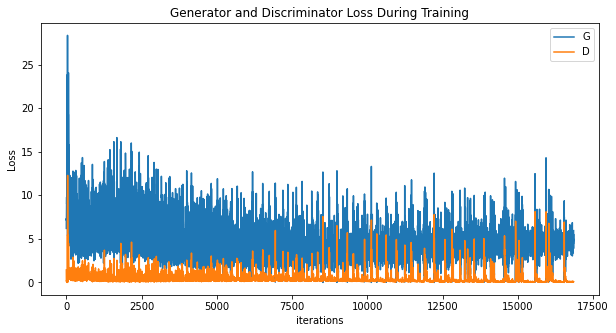

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

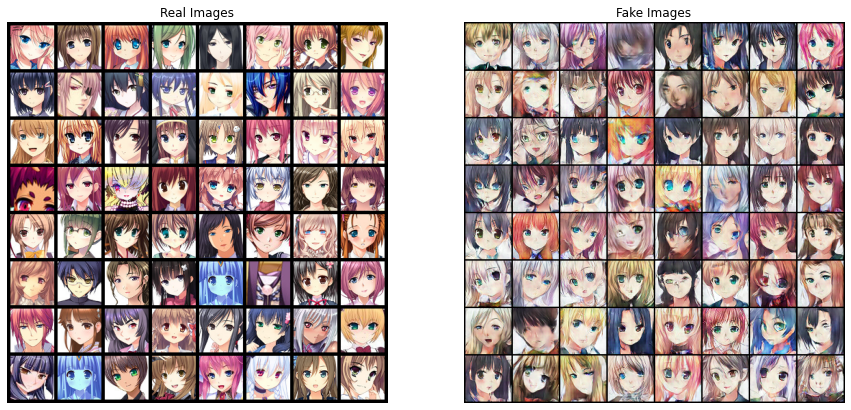

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()